# Определение перспективного тарифа для телеком компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Необходимо определить какой тариф приносит больше денег: «Смарт» или «Ультра»

Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* 		минута разговора: 3 рубля
* 		сообщение: 3 рубля
* 		1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* 		минута разговора: 1 рубль
* 		сообщение: 1 рубль
* 		1 Гб интернет-трафика: 150 рублей

Для ответа на данный вопрос, проанализируем данные 500 пользователей «Мегалайна» за 2018 год.

Оглавление:
1. [Общаяя информация о данных](#step1)
2. [Предобработка данных](#step2)
3. [Анализ данных](#step3) 
4. [Проверка гипотез](#step4) 
5. [Общий вывод](#step5)


## Общая информация о данных <a id="step1"></a> 

Импортируем необходимые для анализа библиотеки. Откроем предоставленные файлы и изучим общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv ('/datasets/internet.csv')
messages = pd.read_csv ('/datasets/messages.csv')
tariffs = pd.read_csv ('/datasets/tariffs.csv')
users = pd.read_csv ('/datasets/users.csv')
alll = [calls, internet, messages, tariffs, users]
for i in alll:
    print(i.info())
    print(i.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
   Unnamed: 0      id  mb_used session_date  user_id
0        

### Вывод 

Данные о 500 пользователях компании Мегалайн представлены в виде 5 таблиц. 

Таблица calls содержит 202607 строк и 4 колонки. Неверно выбран формат для даты. Пропусков нет.

internet 149396 строк и 5 столбцов. Столбец "Unnamed: 0" не несет ценной для нас информации, и скорее всего идентичен индексу. Неверно выбран формат для даты. Пропусков нет.

messages 123036 строк и 3 столбца. Неверно выбран формат для даты. Пропусков нет.

users 500 строк и 8 столбцов. Есть пропуски. Неверно выбран формат для даты.

В таблице tariffs собрана информация о 2-х тарифах.

 ## Предобработка данных <a id="step2"></a> 

Проверим пропуски, заменим ошибочные значения,проверим регистр и дубликаты. Проведем,необходимые для дальнейшего анализа, расчеты. Oбратимся отдельно к каждой таблице.

### calls

Преобразуем столбец call_date в формат datetime.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Добавим в таблицу столбец с номером месяца звонков.

In [4]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
calls.head(5)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Отсортируем таблицу без 0, так как оператор списывает 1 минуту при значениях строго больше 0, а здесь видимо абонент не дозвонился. Количество звонков в тарифах не учитывается, а нам при расчетах средних и тд они могут навредить. 
Так же округлим продолжительность звонка до минут в большую сторону, согласно условиям тарифов.

In [5]:
calls_new = calls.query('duration != 0').reset_index(drop = True)
calls_new['duration'] = np.ceil( calls_new['duration'])
calls_new.head(5)

,id,call_date,duration,user_id,month
0,1000_2,2018-06-11,3.0,1000,6
1,1000_3,2018-09-21,14.0,1000,9
2,1000_4,2018-12-15,6.0,1000,12
3,1000_7,2018-08-22,19.0,1000,8
4,1000_8,2018-09-15,19.0,1000,9


### internet

Преобразуем столбец session_date в формат datetime, удалим лишний столбец Unnamed: 0 и округлим потреченные мегабайты до целого в большую сторону, согласно условиям тарифов. Добавим в таблицу столбец с номером месяца выхода в интернет.

In [6]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet.drop(['Unnamed: 0'], axis = 1, inplace = True)
internet['mb_used'] = np.ceil(internet['mb_used'])
internet['month'] = pd.to_datetime(internet['session_date']).dt.month
internet.head(5)

,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


### messages

Преобразуем столбец message_date в формат datetime и добавим в таблицу столбец с номером месяца отправки смс.

In [7]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
messages.head(5)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


### users

Заменим пропуски в столбце churn_date на 31 декабря 2018, т.к. данные предоставлены за 2018 год и получется что 31 декабря последний день использования тарифа для действующих пользователей в 2018 году.

In [8]:
users['churn_date'] = users['churn_date'].fillna('2018-12-31')
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Преобразуем столбцы churn_date и reg_date в формат datetime. Приведем столбцы tariff и city к нижнему регистру. 

In [9]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['tariff'] = users['tariff'].str.lower()
users['city'] = users['city'].str.lower()
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Для дальнейшего анализа данные этой таблице нужны в сокращенном варианте. Создадим обрезанную таблицу с id пользователя, городом и названием тарифа.

In [10]:
users_cut = users[['user_id','tariff', 'city']]
users_cut.head(5)

,user_id,tariff,city
0,1000,ultra,краснодар
1,1001,smart,москва
2,1002,smart,стерлитамак
3,1003,ultra,москва
4,1004,ultra,новокузнецк


### tariffs

Переименуем название столбцов для более сжатого вывода.

In [11]:
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
tariffs.set_axis(['mes_in','mb_in','min_in','price', 'rub_gb','rub_mes', 'rub_min', 'tariff'], axis = 'columns',inplace = True)
tariffs.head(5)

,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Дубликаты

Проверим данные на наличие дубликатов. В каждой таблице присутсвует уникальный id, поэтому не обязательно приводить все данные в унифицированную форму.

In [13]:
for i in alll:
    print(i[i.duplicated()])

Empty DataFrame
Columns: [id, call_date, duration, user_id, month]
Index: []
Empty DataFrame
Columns: [id, mb_used, session_date, user_id, month]
Index: []
Empty DataFrame
Columns: [id, message_date, user_id, month]
Index: []
Empty DataFrame
Columns: [mes_in, mb_in, min_in, price, rub_gb, rub_mes, rub_min, tariff]
Index: []
Empty DataFrame
Columns: [user_id, age, churn_date, city, first_name, last_name, reg_date, tariff]
Index: []


Дубликаты не обнаружены.

### Дополнительные расчеты

Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам соответственно. Для подсчета количества используем полные данные, для минут - данные без 0.

In [14]:
count_calls = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'count').reset_index()
count_calls.head(5)

,user_id,month,duration
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


In [15]:
sum_calls = calls_new.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'sum').reset_index()
sum_calls.head(5)

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0


Количество отправленных сообщений по месяцам:

In [16]:
count_messages = messages.pivot_table(index = ['user_id','month'], values = 'message_date', aggfunc = 'count').reset_index()
count_messages.head(5)

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Объем израсходованного интернет-трафика по месяцам:

In [17]:
count_internet = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum').reset_index()
count_internet.head(5)

,user_id,month,mb_used
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


### Помесячная выручка с каждого пользователя

Для расчета помесячной выручки с каждого пользователя объеденим таблицы израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам и объем израсходованного интернет-трафика по месяцам. Объединение будем производить по паре user_id, month. В общую таблицу собираем все данные, не зависимо от того есть ли они только в правой или только в левой таблицах.

In [18]:
join1 = sum_calls.merge(count_internet, on = ['user_id','month'], how = 'outer')
join2 = join1.merge(count_messages, on = ['user_id','month'], how = 'outer')
join2.head(5)

,user_id,month,duration,mb_used,message_date
0,1000,5,159.0,2256.0,22.0
1,1000,6,172.0,23257.0,60.0
2,1000,7,340.0,14016.0,75.0
3,1000,8,408.0,14070.0,81.0
4,1000,9,466.0,14581.0,57.0


Не все пользователи каждый месяц пользуются услугами и интернета, и звонками, и сообщениями. Заменим na на 0.

In [19]:
join2[['duration','mb_used','message_date']] = join2[['duration','mb_used','message_date']].fillna(0)
join2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
user_id         3214 non-null int64
month           3214 non-null int64
duration        3214 non-null float64
mb_used         3214 non-null float64
message_date    3214 non-null float64
dtypes: float64(3), int64(2)
memory usage: 150.7 KB


Объеденим таблицу с информацией о пользователях с информацией о тарифах. Объединение проведем по столбцу tariff

In [20]:
users_tariff = users_cut.merge(tariffs, on = 'tariff', how = 'left')
users_tariff.head(5)

,user_id,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min
0,1000,ultra,краснодар,1000,30720,3000,1950,150,1,1
1,1001,smart,москва,50,15360,500,550,200,3,3
2,1002,smart,стерлитамак,50,15360,500,550,200,3,3
3,1003,ultra,москва,1000,30720,3000,1950,150,1,1
4,1004,ultra,новокузнецк,1000,30720,3000,1950,150,1,1


Объединим 2 итоговые таблицы в одну. Получим данные о том сколько расходуют минут, мб и сообщений пользователи по месяцам и сколько это стоит на данном тарифе.

In [21]:
join_all = join2.merge(users_tariff, on = 'user_id')
join_all.head(5)

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min
0,1000,5,159.0,2256.0,22.0,ultra,краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,23257.0,60.0,ultra,краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,14016.0,75.0,ultra,краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,14070.0,81.0,ultra,краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,14581.0,57.0,ultra,краснодар,1000,30720,3000,1950,150,1,1


Посчитаем сколько тратят пользователи по месяцам на дополнительные минуты разговора сверх тарифа.

In [22]:
for i in range (len(join_all['user_id'])):
    if join_all.loc[i,'duration'] > join_all.loc[i,'min_in']:
        join_all.loc[i,'calls'] = (join_all.loc[i,'duration'] - join_all.loc[i,'min_in'])* join_all.loc[i,'rub_min']
    else: 
        join_all.loc[i,'calls'] = 0   
join_all.head(5)           

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,calls
0,1000,5,159.0,2256.0,22.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0
1,1000,6,172.0,23257.0,60.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0
2,1000,7,340.0,14016.0,75.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0
3,1000,8,408.0,14070.0,81.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0
4,1000,9,466.0,14581.0,57.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0


Посчитаем сколько тратят пользователи по месяцам на дополнительные мб трафика сверх тарифа.

In [23]:
for i in range (len(join_all['user_id'])):
    if join_all.loc[i,'mb_used'] > join_all.loc[i,'mb_in']:
        join_all.loc[i,'inet'] = ((join_all.loc[i,'mb_used'] - join_all.loc[i,'mb_in'])//1024 +1)* join_all.loc[i,'rub_gb']
    else: 
        join_all.loc[i,'inet'] = 0   
join_all.head(5)

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,calls,inet
0,1000,5,159.0,2256.0,22.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0
1,1000,6,172.0,23257.0,60.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0
2,1000,7,340.0,14016.0,75.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0
3,1000,8,408.0,14070.0,81.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0
4,1000,9,466.0,14581.0,57.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0


Посчитаем сколько тратят пользователи по месяцам на дополнительные сообщения сверх тарифа.

In [24]:
for i in range (len(join_all['user_id'])):
    if join_all.loc[i,'message_date'] > join_all.loc[i,'mes_in']:
        join_all.loc[i,'message'] = (join_all.loc[i,'message_date'] - join_all.loc[i,'mes_in'])* join_all.loc[i,'rub_mes']
    else: 
        join_all.loc[i,'message'] = 0   
join_all.head(5) 

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,calls,inet,message
0,1000,5,159.0,2256.0,22.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6,172.0,23257.0,60.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7,340.0,14016.0,75.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8,408.0,14070.0,81.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9,466.0,14581.0,57.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


Для расчета помесячной выручки с каждого пользователя, прибавим абонентскую плату, соответствующую тарифному плану к дополнительным тратам пользователей по месяцам сверх тарифа.

In [25]:
for i in range (len(join_all['user_id'])):
    join_all.loc[i,'sum'] = join_all.loc[i,'price'] + join_all.loc[i,'calls'] + join_all.loc[i,'inet'] + join_all.loc[i,'message']
join_all.head(5) 

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,calls,inet,message,sum
0,1000,5,159.0,2256.0,22.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6,172.0,23257.0,60.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7,340.0,14016.0,75.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8,408.0,14070.0,81.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9,466.0,14581.0,57.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


### Вывод

В ходе предобработки данных мы получили сводную таблицу по паре пользователь-месяц, в которой содержится информация о тарифе пользователя, абоненской и дополнительных платах и его месячных расходов по минутам, интернет-трафику и сообщениям.
Используя эти данные мы рассчитали месячные суммы рассходов для пользователей.

## Анализ данных <a id="step3"></a> 


Разделим объединенные данные по признаку принадлежности к тарифу.

In [26]:
ultra = join_all.query('price == 1950')
ultra.name = 'ultra'
count = len(ultra['user_id'].unique())
print('Число пользователей тарифа Ultra', count, 'человек')

Число пользователей тарифа Ultra 148 человек


In [27]:
smart = join_all.query('price == 550')
smart.name = 'smart'
count = len(smart['user_id'].unique())
print('Число пользователей тарифа Smart', count, 'человек')

Число пользователей тарифа Smart 350 человек


Посчитаем среднее количество, дисперсию и стандартное отклонение 

In [28]:
tarif = [smart, ultra]
col = ['duration', 'mb_used', 'message_date']
for i in tarif:
    print(i.name) 
    for n in col:
        mean = i[n].mean()
        var = np.var(i[n],ddof = 1)
        std = np.std(i[n],ddof = 1)
        min = mean - 1.96*std
        max = mean + 1.96*std
        print(n)
        print('Среднее количество в месяц: {:.0f}'.format(mean))
        print('Дисперсия: {:.0f}'.format(var))
        print('Стандартное отклонение: {:.0f}'.format(std))
        print('Нижняя граница: {:.0f}'.format(min))
        print('Верхняя граница: {:.0f}'.format(max))
    print()

smart
duration
Среднее количество в месяц: 418
Дисперсия: 36219
Стандартное отклонение: 190
Нижняя граница: 45
Верхняя граница: 791
mb_used
Среднее количество в месяц: 16229
Дисперсия: 34545911
Стандартное отклонение: 5878
Нижняя граница: 4709
Верхняя граница: 27749
message_date
Среднее количество в месяц: 33
Дисперсия: 797
Стандартное отклонение: 28
Нижняя граница: -22
Верхняя граница: 89

ultra
duration
Среднее количество в месяц: 527
Дисперсия: 100874
Стандартное отклонение: 318
Нижняя граница: -96
Верхняя граница: 1149
mb_used
Среднее количество в месяц: 19487
Дисперсия: 101935621
Стандартное отклонение: 10096
Нижняя граница: -302
Верхняя граница: 39276
message_date
Среднее количество в месяц: 49
Дисперсия: 2285
Стандартное отклонение: 48
Нижняя граница: -44
Верхняя граница: 143



В среднем по выборке пользователи тарифа Smart расходуют 418 минут, 16238 мб и 33 сообщений в месяц. 
Получается что с вероятностью 95 % истинное среднее значение генеральной совокупности находится в интервале 45 — 792 минуты, 4713 — 27762 мб и 0 — 89 смс в месяц.

Аналогично пользователи тарифа Ultra в среднем расходуют 527 минут, 19489 мб и 49 сообщения в месяц. И для них с вероятностью 95 % истинное среднее значение генеральной совокупности находится в интервале 0 — 1150 минут, 0 — 39280 мб и 0 — 143 смс в месяц.


Построим гистограммы 

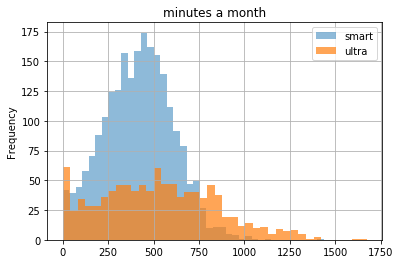

In [29]:
a1 = smart['duration'].plot(kind = 'hist',  grid = True, alpha = 0.5, bins = 40, label = 'smart') 
ultra['duration'].plot(kind = 'hist', grid = True, ax = a1, alpha = 0.7, bins = 40,label = 'ultra', title = 'minutes a month')
plt.legend()

График распределения продолжительности разговоров в минутах в месяцам  по пользователям тарифа ultra более пологий, чем у тарифа smart. Гистограмма тарифа smart в большей степени стремится к нормальному распределению, чем гистограмма тарифа ultra. Из этого можно сделать вывод, что с большей точностью можно определить среднюю продолжительность звонков в месяц на тарифе smart, чем на тарифе ultra. Возможно это связано с количеством пользователей. На тарифе ultra их меньше более чем в 2 раза.

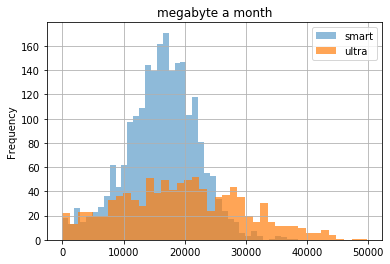

In [30]:
a2 = smart['mb_used'].plot(kind = 'hist',  grid = True, alpha = 0.5, bins = 40, label = 'smart') 
ultra['mb_used'].plot(kind = 'hist', grid = True, ax = a2, alpha = 0.7, bins = 40, label = 'ultra', title = 'megabyte a month')
plt.legend()

Аналогично времени разговоров в месяц распределены израсходованные мегабайты. Гистограмма тарифа smart в большей степени стремится к нормальному распределению, а гистограмма тарифа ultra более пологая. Так же в тарифе ultra присутсвуют высокие единичные значения. 
С большей точностью можно определить среднее количество использованных мегабайт на тарифе smart. 

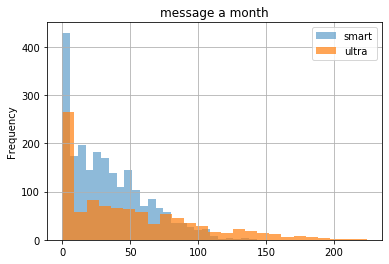

In [31]:
a3 = smart['message_date'].plot(kind = 'hist',  grid = True, alpha = 0.5, bins = 25, label = 'smart') 
ultra['message_date'].plot(kind = 'hist', grid = True, ax = a3, alpha = 0.7, bins = 25, label = 'ultra',title = 'message a month')
plt.legend()

Графики количества отправленных сообщений в месяц имеют пики в самом начале, это может быть связано с тем, что многие пользователи предпочитают мессенджеры стандартным смс. Гистограмма распределения количества отправленных сообщений в месяц по пользователям тарифа ultra более пологая, чем у тарифа smart. 

Рассчитаем среднюю выручку тарифов «Ультра» и «Смарт»

In [32]:
sum = ultra['sum'].mean()
print('Среднемесячная выручка с пользователя тарифа ultra: {:.0f} рубль'.format(sum))
sum1 = smart['sum'].mean()
print('Среднемесячная выручка с пользователя тарифа smart: {:.0f} рубль'.format(sum1))

Среднемесячная выручка с пользователя тарифа ultra: 2071 рубль
Среднемесячная выручка с пользователя тарифа smart: 1295 рубль


### Вывод

При сравнении поведения пользователей 2-х тарифов мы получили следующие данные:

Пользователи тарифа Смарт в среднем по выборке расходуют 418 минут из 500 включенных в тарифный план, 16238 Мб интернет-трафика, включено 15360 Мб и 33 из 50 сообщений в месяц. 

Пользователи тарифа Ультра в среднем по выборке тратят 527 минут из 3000 включенных в тарифный план, 19489 Мб интернет-трафика, включено 30720 Мб и 49 из 1000 сообщений в месяц.

## Проверка гипотез <a id="step4"></a> 

Для ответа на вопрос "Какой тариф приносит больше денег?", рассчитаем среднюю выручку тарифов «Ультра» и «Смарт». Для визуализации постоим гистограммы распределения.

In [33]:
sum = ultra['sum'].mean()
print('Среднемесячная выручка с пользователя тарифа ultra: {:.0f} рубль'.format(sum))
sum1 = smart['sum'].mean()
print('Среднемесячная выручка с пользователя тарифа smart: {:.0f} рублей'.format(sum1))

Среднемесячная выручка с пользователя тарифа ultra: 2071 рубль
Среднемесячная выручка с пользователя тарифа smart: 1295 рублей


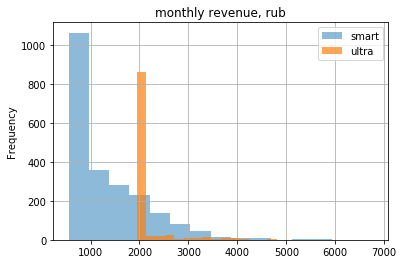

In [34]:
a4 = smart['sum'].plot(kind = 'hist',  grid = True, alpha = 0.5, bins = 15, label = 'smart') 
ultra['sum'].plot(kind = 'hist', grid = True, ax = a4, alpha = 0.7,bins = 15, label = 'ultra', title = 'monthly revenue, rub')
plt.legend()

По данным выборки среднемесячная выручка с пользователя тарифа ultra составила 2071 рубль, а с пользователя тарифа smart - 1296 рублей. Так как мы исследуем только часть пользователей, делать вывод о том ,что полученная разница статистически значима мы не можем.

Предположим что различий между среднемесячной выручки с пользователя тарифа ultra и с пользователя тарифа smart нет. То есть среднее в генеральных совокупностях пользователей тарифов smart и ultra равны. Это и будет нулевой гипотезой. Тогда альтернативной гипотезой будет: "Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается". 

Для рассчета p уровня значимости данной гипотезы воспользуемся Т-тестом. Предварительно рассчитаем дисперсии выручки на тарифах. 

In [35]:
var_smart = np.var(smart['sum'],ddof = 1)
var_ultra = np.var(ultra['sum'],ddof = 1)
print('Дисперсия на тарифе smart равна: {:.0f}'.format(var_smart))
print('Дисперсия на тарифе ultra равна: {:.0f}'.format(var_ultra))

Дисперсия на тарифе smart равна: 674394
Дисперсия на тарифе ultra равна: 143491


По условиям Т-теста, желательно что бы дисперсии внутри групп были примерно равны. У нас этого нет, укажем это в параметре теста. Пороговое значение для p зададим 0,05

In [36]:
alpha = 0.05
results = st.ttest_ind(ultra['sum'], smart['sum'],equal_var = False) 
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.7780713628111093e-246
Отвергаем нулевую гипотезу


По результатам Т-теста, мы отвергли нулевую гипотезу, значит с вероятностью 95% средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Проверим имеет ли статистически значимое различие среднемесячная выручка с пользователей из Москвы и выручка пользователей из других регионов. Сгруппируем отдельно пользователей по Москве и регионам.

In [37]:
msk = join_all.query('city == "москва"')
msk.head(5)

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,calls,inet,message,sum
8,1001,11,430.0,18452.0,0.0,smart,москва,50,15360,500,550,200,3,3,0.0,800.0,0.0,1350.0
9,1001,12,414.0,14053.0,0.0,smart,москва,50,15360,500,550,200,3,3,0.0,0.0,0.0,550.0
17,1003,8,380.0,8571.0,37.0,ultra,москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
18,1003,9,961.0,12479.0,91.0,ultra,москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
19,1003,10,855.0,14779.0,83.0,ultra,москва,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


In [38]:
outher = join_all.query('city != "москва"')
outher.head(5)

,user_id,month,duration,mb_used,message_date,tariff,city,mes_in,mb_in,min_in,price,rub_gb,rub_mes,rub_min,calls,inet,message,sum
0,1000,5,159.0,2256.0,22.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6,172.0,23257.0,60.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7,340.0,14016.0,75.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8,408.0,14070.0,81.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9,466.0,14581.0,57.0,ultra,краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


Рассчитаем среднемесячную выручку и постороим гистограмму распределения.

In [39]:
sum = msk['sum'].mean()
print('Среднемесячная выручка с пользователей из Москвы: {:.0f} рубль'.format(sum))
sum1 = outher['sum'].mean()
print('Среднемесячная выручка с пользователей из регионов: {:.0f} рублей'.format(sum1))

Среднемесячная выручка с пользователей из Москвы: 1551 рубль
Среднемесячная выручка с пользователей из регионов: 1528 рублей


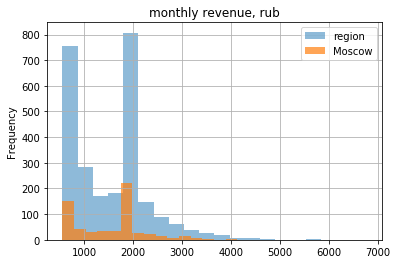

In [40]:
a5 = outher['sum'].plot(kind = 'hist',  grid = True, alpha = 0.5, bins = 20, label = 'region') 
msk['sum'].plot(kind = 'hist', grid = True, ax = a5, alpha = 0.7,bins = 20, label = 'Moscow', title = 'monthly revenue, rub')
plt.legend()

На графике видно 2 всплеска, это стоимость абонентской платы по тарифам ультра и смарт. У графика распределения для пользователей из регионов более длинный хвост. Но в целом критичных выбросов нет. Т-тест проводить можно.

Сформулируем нулевую гипотезу: "среднемесячная выручка с пользователей в Москве и регионах равна". Тогда альтернативной гипотезой будет: "Cредняя выручка с пользователей в Москве и регионах различается". 

Для рассчета p уровня значимости данной гипотезы воспользуемся Т-тестом. Предварительно рассчитаем дисперсии выручки на тарифах. 

In [41]:
var_outher = np.var(outher['sum'],ddof = 1)
var_msk = np.var(msk['sum'],ddof = 1)
print('Дисперсия в Москве равна: {:.0f}'.format(var_msk))
print('Дисперсия в других регионах равна: {:.0f}'.format(var_outher))

Дисперсия в Москве равна: 566183
Дисперсия в других регионах равна: 657127


По условиям Т-теста, желательно что бы дисперсии внутри групп были примерно равны. У нас этого нет, укажем это в параметре теста. Пороговое значение для p зададим 0,05

In [42]:
alpha = 0.05 
results = st.ttest_ind(msk['sum'], outher['sum'], equal_var = False) 
print('p-значение:', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5141223660102104
Не получилось отвергнуть нулевую гипотезу


По результатам теста не получилось отвергнуть нулевую гипотезу, то есть с вероятностью в 95% статистически значимой разницы между среднемесячной выручкой с пользователя в Москве и в регионах нет.

### Вывод 

Мы сегментировали пользователей компании «Мегалайн» по пренадлежности к используемому тарифу и по территориальному признаку.

В результате анализа, по данным выборки, было выявлено, что в среднем в месяц пользователь тарифа ultra тратит на 775 рублей больше, чем пользователь тарифа smart. И эта разница статистически значима.

По данным выборки, в среднем в месяц пользователь из Москвы тратит на 22 рубля больше, чем пользователь из региона. Но эта разница статистически не значима.

## Общий вывод <a id="step5"></a> 

По данным компании «Мегалайн» — федерального оператора сотовой связи, был проведен предварительный анализ тарифов на небольшой выборке клиентов (500 пользователей).

Была проведена подготовка данных. Преобразованы форматы данных, произведена проверка на дубликаты. Получена сводная таблица по паре пользователь-месяц, в которой содержится информация о тарифе пользователя, абоненской и дополнительных платах и его месячных расходов по минутам, интернет-трафику и сообщениям. По данным таблицы расчитаны и добавлены месячные суммы рассходов для каждого пользователя.

В ходе анализа получены следующие результаты:

Пользователи тарифа Смарт в среднем по выборке расходуют 418 минут из 500 включенных в тарифный план, 16238 Мб интернет-трафика, включено 15360 Мб и 33 из 50 сообщений в месяц.
Пользователи тарифа Ультра в среднем по выборке тратят 527 минут из 3000 включенных в тарифный план, 19489 Мб интернет-трафика, включено 30720 Мб и 49 из 1000 сообщений в месяц.

Среднемесячная выручка с пользователя тарифа Ультра составляет 2071 рубль, с пользователя тарифа Смарт 1296 рублей, что на на 775 рублей меньше. С вероятностью 95% данная разница статистически значима. Статистически значимой разницы в выручке с пользователей из Москвы и регионов не обнаружено.

На основании полученных данных, для увеличения среднемесячной выручки с пользователя, можно рекомендовать корректировку рекламного бюджета в пользу тарифа "Ультра". 